# Social Networks - Assignment 4

This **Home Assignment** is **mandatory**, it does count towards your final chance to take part in the exam. 

You can expect numpy, torch, torch_geometric, matplotlib, and networkx to be installed.

## Formalities

**Submit in a group of 3-4 people until 10.07.2022 23:59CET. The deadline is strict!**

You have the opportunity for an prelim submission until 07.07.2022 23:59 CET. We will run your code once, and you can thus see whether there are small bugs that you might not have expected.

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi-automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for only the mean, prints an output instead of returning it!)

In [1]:
# credentials of all team members (you may add or remove members from the list)
team_members = [
    {
        'first_name': 'Tobias',
        'last_name': 'Holtdirk',
        'student_id': 344175
    },
    {
        'first_name': 'Asma',
        'last_name': 'Aziz',
        'student_id': 426774
    },
    {
        'first_name': 'Seyed Pouria',
        'last_name': 'Mirelmi',
        'student_id': 416910
    }
]

In [2]:
# As usual all provided output was obtained with the following torch version
#  different outputs could be possible with different package version
import torch
print(torch.__version__) #1.10.1
import torch_geometric
print(torch_geometric.__version__) # 2.0.4

/home/tholtdirk/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.2
2.0.4


## You own GCN (5)

Create a GCN layer as introduced in the lecture (compare deck 09 slide 62, without the activation function) using PyTorch Geometric. Therefore, use the `MyGCN` class provided below and add code to the `forward` and `message` functions. 

While in the lecture the normalization constant $c_i$ is $|N(i)|$, for this task we are using a normalization function of $c_i = \sqrt{|N_{\text{in}}(i)| |N_{\text{out}}(i)|}$ which for undirected networks comes out to be equal to the lecture definition.

Notice that datasets that we encounter later on are (potentially) directed.

In [3]:
import torch
from torch.nn import Linear, Parameter
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

class MyGCN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        
        
        self.W0 = Linear(in_channels, out_channels, bias=False)
        self.W1 = Linear(in_channels, out_channels, bias=False)
        self.b = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()
        
    def reset_parameters(self):
        self.W0.reset_parameters()
        self.W1.reset_parameters()
        self.b.data.zero_()
        
    def forward(self, x, edge_index):    
        """Implement most of the work here
        Notice that pytorch geometric MessagePassing class inherits self.propagate
          which essentially already has most of the message passing implemented already
        """
        x_w0 = self.W0(x)
        x_w1 = self.W1(x)
        outgoing_edge, incoming_edge = edge_index
        tmp = (degree(outgoing_edge, x.size(0)) * degree(incoming_edge, x.size(0))).pow(-0.5)
        tmp[tmp == float('inf')] = 0
        norm = tmp[outgoing_edge]
        out = self.propagate(
            edge_index=edge_index,
            x=x_w1,
            norm=norm,
            )
        # out -= tmp.view(-1, 1) * x_w1
        out += x_w0
        out += self.b
        return out
    
    def message(self, x_j, norm):
        """Implement normalisation here"""
        return norm.view(-1, 1) * x_j

### Create example Graph (deck 09 slide 64)

In [4]:
import networkx as nx

In [5]:
s = """0 1
0 2
0 3
1 0
1 2
1 3
2 0
2 1
2 4
3 0
3 1
3 4
4 2
4 3
4 5
5 4
5 6
5 7
6 5
6 8
6 9
7 5
7 8
7 9
8 6
8 7
8 9
9 7
9 6
9 8"""

In [6]:
edges = []
for line in s.splitlines():
    a, b = line.split(" ")
    edges.append((int(a),int(b)))

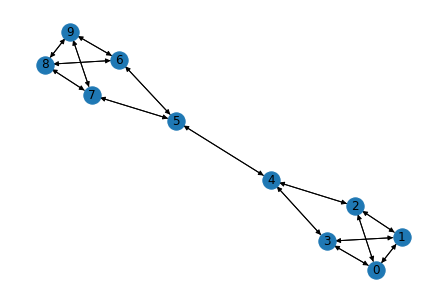

In [7]:
G = nx.DiGraph(edges)
my_pos = nx.spring_layout(G, seed = 4)
nx.draw(G, pos=my_pos, with_labels=True)

### Reproduce the lecture results (2)

In the lecture, you have seen one special case of a GCN (on deck 09 slides 64 you find the definition). To reproduce the results of this case here, we need two functions `create_initial_embeddings` (returning the initial embeddings as specified on the lecture slide and `set_weights` (adjusting the weights of the GCN to be equal to those of the lecture slide, no output). Implement both functions below.


In [8]:
def create_initial_embeddings():
    """Your code here"""
    initial_embedding = [(1,0) if n in [4,5] else (0,1) for n in range(10)]
    return torch.tensor(initial_embedding,dtype=torch.float)

In [9]:
initial_embed = create_initial_embeddings()
initial_embed.shape #torch.Size([10, 2])

torch.Size([10, 2])

In [10]:
def set_weights(layer: MyGCN):
    with torch.no_grad():
        layer.W0.weight.fill_(0.)
        layer.W0.weight[0,0] = 1.
        layer.W1.weight.fill_(0.)
        layer.W1.weight[1,0] = 1.
        layer.b.fill_(0.)
        return layer

In [11]:
# Test
layer = MyGCN(2,2)
set_weights(layer)

MyGCN()

In [12]:
layer.W0.weight

#Parameter containing:
#tensor([[1., 0.],
#        [0., 0.]], requires_grad=True)

Parameter containing:
tensor([[1., 0.],
        [0., 0.]], requires_grad=True)

In [13]:
layer.W1.weight

#Parameter containing:
#tensor([[0., 0.],
#        [1., 0.]], requires_grad=True)

Parameter containing:
tensor([[0., 0.],
        [1., 0.]], requires_grad=True)

In [14]:
layer.b

#Parameter containing:
#tensor([0., 0.], requires_grad=True)

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [15]:
edge_index = torch.tensor(edges, dtype=torch.long).T
edge_index

#tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7,
#         8, 6, 8, 9, 9, 9],
#        [1, 2, 3, 0, 2, 3, 0, 1, 4, 0, 1, 4, 2, 3, 5, 4, 6, 7, 5, 8, 9, 5, 8, 9,
#         6, 7, 9, 7, 6, 8]])

tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7,
         8, 8, 8, 9, 9, 9],
        [1, 2, 3, 0, 2, 3, 0, 1, 4, 0, 1, 4, 2, 3, 5, 4, 6, 7, 5, 8, 9, 5, 8, 9,
         6, 7, 9, 7, 6, 8]])

In [16]:
layer(initial_embed, edge_index)
#tensor([[0.0000, 0.0000],
#        [0.0000, 0.0000],
#        [0.0000, 0.3333],
#        [0.0000, 0.3333],
#        [1.0000, 0.3333],
#        [1.0000, 0.3333],
#        [0.0000, 0.3333],
#        [0.0000, 0.3333],
#        [0.0000, 0.0000],
#        [0.0000, 0.0000]], grad_fn=<AddBackward0>)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.3333],
        [0.0000, 0.3333],
        [1.0000, 0.3333],
        [1.0000, 0.3333],
        [0.0000, 0.3333],
        [0.0000, 0.3333],
        [0.0000, 0.0000],
        [0.0000, 0.0000]], grad_fn=<AddBackward0>)

In [17]:
torch.manual_seed(1)
layer(torch.rand(initial_embed.shape), edge_index)
#tensor([[0.7576, 0.2765],
#        [0.4031, 0.3947],
#        [0.0293, 0.5767],
#        [0.3971, 0.5767],
#        [0.5695, 0.3550],
#        [0.6387, 0.5719],
#        [0.6826, 0.7161],
#        [0.4635, 0.7161],
#        [0.5725, 0.6944],
#        [0.9371, 0.5729]], grad_fn=<AddBackward0>)

tensor([[0.7576, 0.2765],
        [0.4031, 0.3947],
        [0.0293, 0.5767],
        [0.3971, 0.5767],
        [0.5695, 0.3550],
        [0.6387, 0.5719],
        [0.6826, 0.7161],
        [0.4635, 0.7161],
        [0.5725, 0.6944],
        [0.9371, 0.5729]], grad_fn=<AddBackward0>)

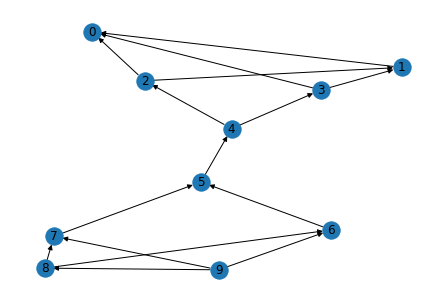

In [18]:
# test on directed network

# orient edges
a, b = edge_index
edge_index2 = edge_index[:,a>b]

G = nx.DiGraph([(int(a), int(b)) for a, b in zip(edge_index2[0,:], edge_index2[1,:])])
my_pos = nx.spring_layout(G, seed = 4)
nx.draw(G, pos=my_pos, with_labels=True)

In [19]:
# directed network continued from above
torch.manual_seed(1)
layer(torch.rand(initial_embed.shape), edge_index2)
#tensor([[0.7576, 0.0000],
#        [0.4031, 0.3015],
#        [0.0293, 0.4027],
#        [0.3971, 0.4027],
#        [0.5695, 0.4516],
#        [0.6387, 0.8105],
#        [0.6826, 1.0674],
#        [0.4635, 1.0674],
#        [0.5725, 0.6626],
#        [0.9371, 0.0000]], grad_fn=<AddBackward0>)

tensor([[0.7576, 0.5865],
        [0.4031, 0.3015],
        [0.0293, 0.4027],
        [0.3971, 0.4027],
        [0.5695, 0.4516],
        [0.6387, 0.8105],
        [0.6826, 0.4048],
        [0.4635, 0.4048],
        [0.5725, 0.0000],
        [0.9371, 0.0000]], grad_fn=<AddBackward0>)

## Multi Layer GCN (3)

We will now use our defined Convolution Layer to create a GCN with variable number of "hidden layers" using the `MultiLayerGCN` class below.

The network always starts with an initial layer mapping node features onto the size of the hidden dim. No activation function is used after this layer. This layer is of shape `node_features_dim` x `hidden_dim`.
Then, we apply `num_hidden_layers` hidden layers of shape `hidden_dim` x `hidden_dim`, each followed by a `ReLu` activation function.
The network terminates with an output layer of shape `hidden_dim ` x `num_classes`  that is followed by a `log_sofmax` activation.

All layers are of type `MyGCN`. For reproducability reasons, layers are initialized in the same order they are traversed in a forward pass. You find a usage example below.

In [20]:
from torch_geometric.datasets import Planetoid

In [50]:
class MultiLayerGCN(torch.nn.Module):
    def __init__(self, node_features_dim, hidden_dim, num_classes, num_hidden_layers=0):
        super().__init__()
        self.layers = []
        """Your code to fill up the layers here"""
        self.activations = []
        # initial_layer = Linear(node_features_dim, hidden_dim, bias=False)
        initial_layer = MyGCN(node_features_dim, hidden_dim)
        self.layers.append(initial_layer)
        self.activations.append(None)
        for _ in range(num_hidden_layers):
            layer = MyGCN(hidden_dim, hidden_dim)
            self.layers.append(layer)
            self.activations.append(F.relu)
        out_layer = MyGCN(hidden_dim, num_classes)
        self.layers.append(out_layer)
        self.activations.append(F.log_softmax)
        
        self.layers = torch.nn.ModuleList(self.layers)

    def forward(self, data):
        """Your code for the forward pass here"""
        x = data.x
        edge_index = data.edge_index
        for activation, layer in zip(self.activations, self.layers):
            x = layer(x, edge_index)
            if activation:
                x = activation(x)
        return x


In [51]:
# example training loop
def training(model, data, n_epochs = 200):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

In [52]:
# checking initialization with fixed seed
torch.manual_seed(1)
tmp_GCN = MultiLayerGCN(3, 2, 2, 0)
print(tmp_GCN.layers[0].W0.weight)
#tensor([[ 0.2109, -0.2250, -0.0421],
#        [-0.0520,  0.0837, -0.0023]], requires_grad=True)
tmp_GCN.layers[1].W0.weight
#tensor([[ 0.4667, -0.6443],
#        [-0.6723, -0.3411]], requires_grad=True)

Parameter containing:
tensor([[ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023]], requires_grad=True)


Parameter containing:
tensor([[ 0.4667, -0.6443],
        [-0.6723, -0.3411]], requires_grad=True)

In [53]:
# checking initialization with fixed seed
torch.manual_seed(1)
tmp_GCN = MultiLayerGCN(3, 2, 2, 1)
for i in range(3):
    print(tmp_GCN.layers[i].W0.weight)
    
# Parameter containing:
#tensor([[ 0.2109, -0.2250, -0.0421],
#        [-0.0520,  0.0837, -0.0023]], requires_grad=True)
#Parameter containing:
#tensor([[ 0.4667, -0.6443],
#        [-0.6723, -0.3411]], requires_grad=True)
#Parameter containing:
#tensor([[-0.2042, -0.0775],
#        [-0.6798, -0.3371]], requires_grad=True)


Parameter containing:
tensor([[ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023]], requires_grad=True)
Parameter containing:
tensor([[ 0.4667, -0.6443],
        [-0.6723, -0.3411]], requires_grad=True)
Parameter containing:
tensor([[-0.2042, -0.0775],
        [-0.6798, -0.3371]], requires_grad=True)


#### Import the Cora dataset

In [25]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', split="public")

In [26]:
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiLayerGCN(dataset.num_node_features, 16, dataset.num_classes, 0).to(device)


data = dataset[0].to(device)

training(model, data)

/tmp/ipykernel_3367520/3076948661.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = activation(x)


#### Evaluate the model on the test set

In [27]:
def get_test_accuracy(model, data):
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

In [28]:
acc = get_test_accuracy(model, data)
print(f'# Accuracy: {acc:.8f}')
# Accuracy: 0.78800000

# Accuracy: 0.73100000


/tmp/ipykernel_3367520/3076948661.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = activation(x)


### Are more layers always better? (3)

You will now look into finding the optimal number of layers that you should use in your Multi-Layer GCN. Therefore, evaluate different configurations on different datasets. For the three datasets `("Cora", "CiteSeer", "PubMed")` compute the accuracy of a fitted `MultiLayerGCN` with `hidden_dim` of 16 and a varying number (`[0, 1, 2, 3, 4]`) of hidden layers.

Repeat the experiment 10 times for each of the settings using a different seed ([0..9]) each time.

Collect the result of the experiments in a dictionary `results` that maps the names of the datasets to list of list. e.g. `results["Cora"][1][2]` holds the results for the Cora dataset with 1 "hidden layer" and an initial seed of 2.

Use the `"public"` splits of the datasets. Plot the mean and standard deviation of the accuracy as a function of hidden layers in an errorbar plot. Save the a plot containing lines for all three datasets as `accuracies.png` here in the notebook.

### What do we observe? (2)

Describe what you see in your own words. Then interpret your findings. Save your text in the `your_observation` variable provided below.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F

In [31]:
from tqdm import tqdm
# computations take about 5 min
results = {"Cora" : [], "CiteSeer" : [], "PubMed" : []}
with tqdm(total=3*5*10) as pbar:
    for dataset_name in ("Cora", "CiteSeer", "PubMed"):
        dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, split="public")
        data = dataset[0].to(device)
        for n_hidden in range(5):
            results[dataset_name].append([])
            for seed in range(10):
                torch.manual_seed(seed) # !set seed before initializing the model!
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                model = MultiLayerGCN(dataset.num_node_features, 16, dataset.num_classes, n_hidden).to(device)
                training(model, data)
                results[dataset_name][n_hidden].append(get_test_accuracy(model, data))
                pbar.update(1)

  0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_3367520/3076948661.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = activation(x)
100%|██████████| 150/150 [22:24<00:00,  8.96s/it]


In [32]:
results
#{'Cora': [[0.79, 0.788, 0.795, 0.806, 0.789, 0.799, 0.8, 0.788, 0.795, 0.796],
#  [0.808, 0.801, 0.798, 0.803, 0.793, 0.781, 0.791, 0.807, 0.804, 0.801],
#  [0.758, 0.762, 0.763, 0.779, 0.776, 0.76, 0.78, 0.779, 0.791, 0.785],
#  [0.758, 0.737, 0.773, 0.65, 0.719, 0.77, 0.745, 0.719, 0.648, 0.693],
#  [0.715, 0.654, 0.738, 0.691, 0.749, 0.765, 0.722, 0.634, 0.706, 0.762]],
# 'CiteSeer': [[0.701,   0.701,   0.697,   0.695,   0.698,   0.697,   0.695,   0.683,   0.701,   0.697],
#  [0.677, 0.665, 0.665, 0.66, 0.673, 0.68, 0.683, 0.674, 0.633, 0.662],
#  [0.612, 0.626, 0.676, 0.658, 0.602, 0.569, 0.619, 0.641, 0.631, 0.567],
#  [0.641, 0.645, 0.575, 0.601, 0.63, 0.627, 0.556, 0.641, 0.499, 0.626],
#  [0.534, 0.498, 0.46, 0.57, 0.517, 0.611, 0.598, 0.602, 0.466, 0.594]],
# 'PubMed': [[0.765,   0.766,   0.764,   0.764,   0.764,   0.764,   0.766,   0.764,   0.767,   0.766],
#  [0.765, 0.762, 0.758, 0.766, 0.766, 0.765, 0.768, 0.766, 0.764, 0.766],
#  [0.769, 0.769, 0.769, 0.766, 0.768, 0.771, 0.767, 0.768, 0.69, 0.768],
#  [0.773, 0.747, 0.734, 0.77, 0.772, 0.772, 0.732, 0.711, 0.728, 0.754],
#  [0.684, 0.748, 0.66, 0.7, 0.747, 0.697, 0.713, 0.617, 0.764, 0.771]]}

{'Cora': [[0.715, 0.731, 0.731, 0.742, 0.72, 0.727, 0.74, 0.734, 0.721, 0.728],
  [0.764, 0.752, 0.725, 0.725, 0.763, 0.749, 0.746, 0.767, 0.755, 0.737],
  [0.708, 0.763, 0.738, 0.742, 0.739, 0.736, 0.754, 0.738, 0.754, 0.737],
  [0.711, 0.756, 0.718, 0.542, 0.706, 0.698, 0.746, 0.689, 0.596, 0.668],
  [0.651, 0.556, 0.745, 0.59, 0.728, 0.72, 0.753, 0.64, 0.722, 0.704]],
 'CiteSeer': [[0.656,
   0.658,
   0.657,
   0.661,
   0.638,
   0.665,
   0.646,
   0.645,
   0.645,
   0.658],
  [0.639, 0.631, 0.669, 0.613, 0.653, 0.672, 0.631, 0.628, 0.609, 0.642],
  [0.561, 0.529, 0.621, 0.572, 0.559, 0.557, 0.617, 0.58, 0.652, 0.501],
  [0.592, 0.539, 0.584, 0.607, 0.595, 0.621, 0.504, 0.586, 0.466, 0.513],
  [0.436, 0.535, 0.563, 0.54, 0.494, 0.566, 0.492, 0.485, 0.536, 0.564]],
 'PubMed': [[0.761,
   0.762,
   0.758,
   0.758,
   0.759,
   0.756,
   0.758,
   0.762,
   0.761,
   0.762],
  [0.774, 0.767, 0.752, 0.776, 0.775, 0.774, 0.778, 0.783, 0.782, 0.774],
  [0.693, 0.794, 0.792, 0.786, 0.

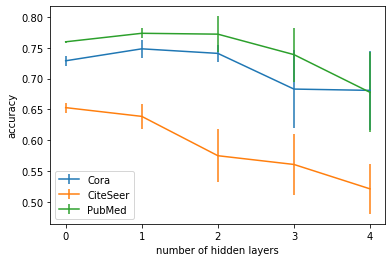

In [38]:
fig, ax = plt.subplots()

for dataset_name in results:
    y = []
    y_error = []
    for accuracies in results[dataset_name]:
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        y.append(mean)
        y_error.append(std)
    x = [str(n) for n in range(len(results[dataset_name]))]
    ax.errorbar(x=x, y=y, yerr=y_error, label=dataset_name)
ax.set_xlabel('number of hidden layers')
ax.set_ylabel('accuracy')
plt.legend()
plt.savefig('accuracies.png')
plt.show()

In [36]:
your_observation = """For the Cora and PubMed dataset, the number of hidden dimension increases the accuracy up to 2 dimensions, after which the accuracy decreases. 
This is opposed to the CiteSeer dataset where the mean accuracy monotonically deacreases with the number of hidden layers from the start. 
The standard deviation increases with all datasets with the number of hidden layers.
The cause for the decrease in mean accuracy and the increase in the standard deviations is likely caused by overfitting of the data, to evaluate this further one has the look at the accuracy for the training data to compare with the accuracy of the test data.
"""